#Introduction

[Colab Notebook Link](https://colab.research.google.com/drive/1OOQ2lUOtsObJvlZpjWRkdKLpi_xca-DO?usp=sharing)

This time we'll perform classification on the basketball dataset using the Pytorch RNN.
Our goal is to compare the efficiency of the base RNN, LSTM, and GRU with the 
feed-forward network that was implemented in part 3. We would like to see if 
any RNN is better at solving this problem than the feed forward network was.


This time, my goal was to understand the Pytorch implementation of RNN, LSTM, and GRU, so I used the following documentation to help me implement my program:

#Learning Pytorch RNN, LSTM, and GRU 

https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

I studied the initial documentation to try and understand the the differences between the three models and their arguments. One initial point that interested me was that RNNs were able to take an argument for a desired activation function - in this case, I used ReLU (Rectified Linear Unit) to once again take gradient values and calculates max(0,z), effectively returning 0 for non positive values and 1 for positive values with the intention of addressing the vanishing gradient problem.  Similar to the previous homework, I used 2 layer networks.

https://stats.stackexchange.com/questions/444923/activation-function-between-lstm-layers

https://stackoverflow.com/questions/49040180/change-tanh-activation-in-lstm-to-relu

https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be

Implementations of LSTM and GRUs typically use sigmoid activation functions (LSTM also uses tanh activation functions), and it is generally assumed that this is the case for packages like Pytorch or Keras. One reason RelU might be viewed as an unfavorable activation function is can return large outputs, which could scale poorly for LSTMs trying to process data piece by piece.


#Tutorials and Debugging

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

https://www.kaggle.com/code/namanmanchanda/rnn-in-pytorch/notebook

https://www.kaggle.com/code/kanncaa1/recurrent-neural-network-with-pytorch/notebook

https://stackoverflow.com/questions/64953102/how-can-i-use-an-lstm-to-classify-a-series-of-vectors-into-two-categories-in-pyt

These tutorials were used to study the implementation of the aforementioned models and debug where necesssary. I struggled a lot with understanding how LSTM handled data, and as a result had to carefully review multiple tutorials until I realized that I was handling both hidden features and hidden layers incorrectly. In the interest of clarity, I have listed all tutorials I used during this debugging process.


In [2]:
!mkdir Athlete_D
!mkdir Athlete_Jc
!mkdir Athlete_L
!mkdir Athlete_X

mkdir: cannot create directory ‘Athlete_D’: File exists
mkdir: cannot create directory ‘Athlete_Jc’: File exists
mkdir: cannot create directory ‘Athlete_L’: File exists
mkdir: cannot create directory ‘Athlete_X’: File exists


#Data Set and Base Requirements

As mentioned above, this is the same dataset from part 3. We will be using it to compare the effectiveness of RNN vs feed-forward network for this problem.

Dataset used https://archive.ics.uci.edu/ml/datasets/Basketball+dataset

The data set is a Time Series dataset, where an athlete's acceleration and angle of acceleration change over the course of athlete's action (as time increases.)

We will use accelerometer data to classify whether a basketball athlete is performing one of five actions in a basketball game: dribble, hold, pass, pickup, or shoot. We expect these classifications will be useful for sports analysts and coaches who are likely interested in whether their athletes are moving the correct way to perform the acting they intend (i.e. am athlete who intends to shoot should not be trying to pass!)

The dataset consists of actions with the following 7 features:


*   1:   Time - The time since the action has started, in seconds.

*   2,3,4:   X,Y,Z - Acceleration of the athlete performing the action, as measured by an accelerometer in m/s^2.

*   5:  R - Acceleration of the athlete as measured by a gyroscope in m/s^2.

*   6,7: Theta, Phi - Angle of acceleration as measured by a gyroscope in  degrees.

Additionally, "dribble, hold, pass, pickup, or shoot" will be assigned as the labels to this dataset, using numbers 0-4.

The data was split among text files and organized by athlete initial and action taken. This setup was leveraged to quickly create a pandas dataframe that properly represented our data as seen in "Loading Data and Peforming Exploratory Data Analysis".



In [4]:
pip install torch torchvision torchaudio torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 6.6 MB/s 
     |████████████████████████████████| 140 kB 64.0 MB/s 
     |████████████████████████████████| 127 kB 66.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [5]:
#import requirements
import numpy as np
import operator
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import math

In [6]:
#pytorch specific utils
import torch
from torch import nn
from torch.utils.data import DataLoader , random_split, Dataset
from torchtext import datasets
from torchtext.transforms import ToTensor
from torchtext.data import get_tokenizer
from torch.autograd import Variable

In [7]:
RANDOM_STATE=233

In [8]:
#check what device we're using
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
torch.set_grad_enabled(True) 

Using cpu device


#Loading Data and Performing Exploratory Data Analysis 

The process is similar to the pre-processing done in Homework 3 as we are trying to solve the same problem with a different model.

Exploratory Data Analysis - Additional comments on dataset, cleaning, and visualization have been provided where needed.

In [9]:
#quick mv command for misplaced files
#mv  *.txt Athlete_D

In [10]:
from os import listdir
from os.path import isfile, join

In [11]:
test_dir = "Athlete_D"
ath_D_array = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]
print(ath_D_array)

['D_shoot4.txt', 'D_shoot5.txt', 'D_dribble1.txt', 'D_pass2.txt', 'D_pickup5.txt', 'D_pass5.txt', 'D_pass6.txt', 'D_pickup2.txt', 'D_hold2.txt', 'D_dribble3.txt', 'D_pickup3.txt', 'D_hold1.txt', 'D_shoot2.txt', 'D_pass3.txt', 'D_shoot1.txt', 'D_pickup4.txt', 'D_pass4.txt', 'D_dribble2.txt', 'D_pass1.txt', 'D_pickup1.txt', 'D_shoot3.txt', 'D_hold3.txt']


In [12]:
#Athletes were categorized by initial, so we sort them accordingly 
#into folders before starting processing
#File names are marked as INITIAL_ACTION(NUMBER).
#We will use the ACTION 
athlete_folders = ["Athlete_D","Athlete_Jc", "Athlete_L", "Athlete_X"]
actions = ["dribble","hold","pass","pickup","shoot"] #label will correspond to index number

In [13]:
#test with reading one file
newcol= "Action"
df = pd.read_table("Athlete_D/D_dribble1.txt", delimiter=",", skiprows=3)
df[newcol]=0

In [14]:
df

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
0,0.000000,3.428497,9.112331,-2.047042,9.948847,101.873802,69.381287,0
1,0.009703,3.447650,9.285912,-2.331953,10.176072,103.247643,69.631172,0
2,0.019734,3.506308,9.212888,-2.244564,10.109875,102.827530,69.163811,0
3,0.029704,3.703830,8.972271,-1.990779,9.908744,101.590256,67.568748,0
4,0.039805,3.902549,8.799889,-1.545457,9.749685,99.120628,66.083809,0
...,...,...,...,...,...,...,...,...
984,9.879907,3.989937,8.725668,-0.760159,9.624694,94.529945,65.427071,0
985,9.889970,4.096479,8.585608,-0.766145,9.543624,94.604553,64.492638,0
986,9.900604,4.034230,8.754398,-0.822408,9.674236,94.876610,65.258652,0
987,9.910431,3.951630,9.159019,-1.513135,10.089231,98.625496,66.662369,0


In [15]:
dfcols = ["Time (s)", "X (m/s2)", "Y (m/s2)", "Z (m/s2)", "R (m/s2)", "Theta (deg)", "Phi (deg)", "Action"]
all_df = pd.DataFrame(columns = dfcols)

In [16]:
all_df

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action


In [17]:
myframes = []
for foldername in athlete_folders:
  textfiles = [f for f in listdir(foldername) if isfile(join(foldername, f))]
  for textfile in textfiles:
    fullpath = foldername + "/" + textfile
    df_temp = pd.read_table(fullpath, delimiter=",", skiprows=3)
    if "dribble" in textfile:
        df_temp["Action"] = 0
    elif "hold" in textfile:
        df_temp["Action"] = 1
    elif "pass" in textfile:
        df_temp["Action"] = 2
    elif "pickup" in textfile:
        df_temp["Action"] = 3
    elif "shoot" in textfile:
        df_temp["Action"] = 4
    else:
        df_temp["Action"] = 5 #this label represents INVALID data.
    myframes.append(df_temp)

In [18]:
len(myframes)

79

In [19]:
all_df = pd.concat(myframes)

In [20]:
#52913 rows × 8 columns
all_df

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
0,0.000000,8.186973,4.508282,-2.455254,9.663301,104.719093,28.840052,4
1,0.016081,8.638280,4.398149,-1.725022,9.845776,100.090546,26.982752,4
2,0.025817,8.955511,4.375403,-0.958878,10.013230,95.495125,26.038795,4
3,0.035936,9.194932,4.273650,-0.556652,10.154838,93.142326,24.928215,4
4,0.045710,9.251195,4.232949,-0.605733,10.191632,93.407349,24.586794,4
...,...,...,...,...,...,...,...,...
574,5.780185,0.017450,0.997584,0.107751,1.003538,83.836189,88.997864,3
575,5.789986,0.026846,0.994167,0.112144,1.000832,83.566437,88.453171,3
576,5.800642,0.034412,0.992093,0.130205,1.001192,82.527542,88.013412,3
577,5.810363,0.058452,0.961830,0.160468,0.976874,80.545372,86.522331,3


In [21]:
invalid_data = df.loc[df['Action'] == 5]

In [22]:
#all of our data is valid actions!
#we have 52913 examples to work with
invalid_data

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action


In [23]:
test= all_df.loc[all_df['Action'] == 3]

In [24]:
test

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
0,0.000000,1.897405,6.508637,7.580042,10.169540,41.809349,73.747482,3
1,0.009813,1.783680,6.707356,7.337031,10.099612,43.409012,75.108047,3
2,0.019684,1.868674,7.147889,7.380127,10.442726,45.030994,75.349052,3
3,0.029636,1.713051,6.873753,7.319075,10.185866,44.064941,76.006027,3
4,0.039645,1.448492,6.623559,7.020997,9.760330,43.999977,77.664307,3
...,...,...,...,...,...,...,...,...
574,5.780185,0.017450,0.997584,0.107751,1.003538,83.836189,88.997864,3
575,5.789986,0.026846,0.994167,0.112144,1.000832,83.566437,88.453171,3
576,5.800642,0.034412,0.992093,0.130205,1.001192,82.527542,88.013412,3
577,5.810363,0.058452,0.961830,0.160468,0.976874,80.545372,86.522331,3


In [25]:
len(test)

15388

In [26]:
#is data balanced?
numdata = []

for i in range (0,5):
  numdata.append(len(all_df.loc[all_df['Action'] == i]))

In [27]:
numdata

[12823, 6369, 11363, 15388, 6970]

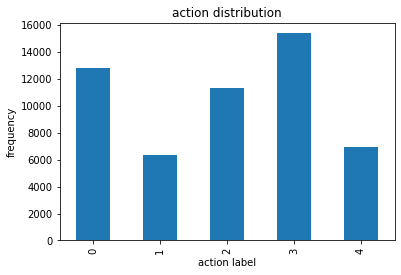

In [28]:
df_nd = pd.DataFrame(numdata, columns=[''])
ax = df_nd.plot(kind='bar', title = "action distribution")
ax.set_xlabel("action label")
ax.set_ylabel("frequency")
ax.get_legend().remove()
plt.show()
#We seem to have less data on the "hold" and "shoot" actions.

In [29]:
#Even if we only took 6369 examples from each dataset, 
#we would still be left with about 30,000 examples and plenty of data
#for train/val/test split
#so let's do that via random selection and rejoin the dataset.
balanced_combiner = []
for i in range (0,5):
  chunk_df = all_df.loc[all_df['Action'] == i]
  balanced_temp = chunk_df.sample(n=6369, random_state=RANDOM_STATE)
  balanced_combiner.append(balanced_temp)
balanced_all = pd.concat(balanced_combiner)
balanced_all = balanced_all.reset_index(drop=True)

In [30]:
balanced_all

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
0,9.286569,7.256825,8.359355,6.147113,12.662043,60.956364,49.038479,0
1,6.639866,6.519411,3.245340,-0.055067,7.282718,90.433235,26.463963,0
2,1.688493,2.024297,9.538500,1.538275,9.871527,81.035095,78.018242,0
3,4.938691,2.151190,8.353370,1.295263,8.722620,81.460297,75.558762,0
4,0.860075,1.766921,9.403227,2.286463,9.837205,76.559814,79.357887,0
...,...,...,...,...,...,...,...,...
31840,0.330058,5.899313,8.258799,0.590171,10.166512,86.672081,54.461536,4
31841,2.780179,4.721366,8.475474,-0.435745,9.711582,92.571640,60.879475,4
31842,4.340031,0.363889,0.911066,0.253575,1.013290,75.507713,68.227707,4
31843,3.950385,2.482787,9.063251,0.579397,9.415011,86.471809,74.680229,4


In [31]:
#Looks balanced!
numdatanew = []
for i in range (0,5):
  numdatanew.append(len(balanced_all.loc[balanced_all['Action'] == i]))
print(numdatanew)

[6369, 6369, 6369, 6369, 6369]


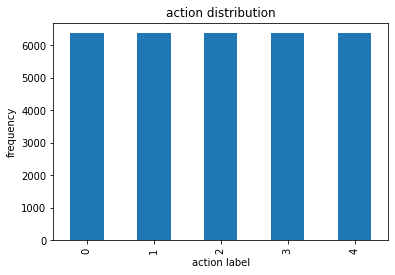

In [32]:
df_nd = pd.DataFrame(numdatanew, columns=[''])
ax = df_nd.plot(kind='bar', title = "action distribution")
ax.set_xlabel("action label")
ax.set_ylabel("frequency")
ax.get_legend().remove()
plt.show()

In [33]:
#Summary of all stats
#Some of the stats - especailly those involve degrees
#vary wildly, as indicated by std.
#We will normalize these following a train/val/test split.
balanced_all.describe()

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
count,31845.000000,31845.000000,31845.000000,31845.000000,31845.000000,31845.000000,31845.000000,31845.000000
mean,3.683098,3.391771,6.546430,1.006166,8.645987,81.229455,75.411486,2.000000
std,2.932378,3.980442,4.079775,2.661092,4.493152,14.820114,51.186228,1.414236
min,0.000000,-39.195477,-14.277822,-33.500866,0.077691,12.856148,0.005464,0.000000
25%,1.528668,0.535340,4.279635,0.064919,8.797799,75.831467,57.243790,1.000000
50%,3.060462,3.308787,7.999028,0.770933,9.833359,80.924576,68.288162,2.000000
75%,5.010264,5.279215,9.096769,1.896208,9.997210,88.917969,77.541512,3.000000
max,20.650665,38.476017,39.221813,28.358122,54.321270,164.085129,359.945709,4.000000


Looking at data this way helps us get a better understanding of what the parameters reference as well. For example, "Time = 0" would be the representation of an athlete's velocty and angular momentum when starting an action. Actions last up to 20 seconds, meaning that an action's other features can vary depending on the time the action is recorded (for example, if an athlete jumped during an action, their vertical velocity would be positive at one point and negative at another.) 

In [34]:
balanced_all.loc[balanced_all['Time (s)'] == 0]

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
478,0.0,0.100063,0.818446,-0.051008,0.826116,93.539940,83.029594,0
584,0.0,3.479972,9.069236,-2.246958,9.970460,103.024139,69.007607,0
2345,0.0,2.612074,9.417592,0.434548,9.782781,87.454102,74.498055,0
5426,0.0,2.408567,9.160215,2.091335,9.699713,77.548805,75.268234,0
6341,0.0,3.180697,8.923190,1.921347,9.666009,78.534752,70.381241,0
6524,0.0,2.998738,9.139865,1.316811,9.708941,82.205025,71.835632,1
7039,0.0,5.863400,7.539341,-0.681150,9.575233,94.079277,52.127537,1
7201,0.0,0.391346,0.826256,0.225021,0.941533,76.172829,64.656006,1
8266,0.0,0.209889,0.836140,0.076756,0.865491,84.912048,75.908676,1
9255,0.0,4.000711,9.130288,1.353921,10.059868,82.265297,66.337921,1


#Create Train Dev Test Split, Normalize Data, and Convert to Pytorch Data Loaders

##Train-Dev-Test Split
Train-dev-test split.

In [35]:
#shuffle dataset
train, test = train_test_split(balanced_all.sample(frac=1, random_state=RANDOM_STATE), test_size=0.2, random_state=RANDOM_STATE)#shuffle dataset
train, val = train_test_split(train.sample(frac=1, random_state=RANDOM_STATE), test_size=0.2, random_state=RANDOM_STATE)

In [36]:
train = train.reset_index(drop=True)
train

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
0,3.709576,-0.106897,1.038830,0.128374,1.052176,82.991982,95.875137,0
1,1.289881,16.652870,-4.095282,-8.127118,18.977341,115.356796,346.183960,4
2,4.119909,6.613982,3.858256,-1.103727,7.736221,98.202377,30.257084,0
3,1.320370,1.868674,9.373300,2.287660,9.827720,76.539421,78.725250,0
4,2.469975,3.408146,9.175778,1.728614,9.939742,79.984810,69.623566,1
...,...,...,...,...,...,...,...,...
20375,4.859580,6.151901,7.656657,0.915782,9.864530,84.673225,51.219135,1
20376,0.769962,4.322731,8.619126,1.618480,9.777260,80.471672,63.364964,4
20377,0.900082,21.413740,0.772130,-9.136273,23.294119,113.092316,2.065059,4
20378,3.229861,3.933673,9.661801,-0.606930,10.449524,93.329735,67.846962,0


In [37]:
train_x = train.loc[:, train.columns != "Action"]
train_x=(train_x-train_x.mean())/train_x.std() #normalize
train_x

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg)
0,0.013578,-0.877431,-1.338175,-0.330052,-1.670880,0.119783,0.397985
1,-0.807542,3.323024,-2.592138,-3.432612,2.287745,2.309548,5.273173
2,0.152823,0.807005,-0.649554,-0.793097,-0.194764,1.148900,-0.880038
3,-0.797195,-0.382299,0.697448,0.481446,0.267127,-0.316789,0.063962
4,-0.407079,0.003535,0.649205,0.271346,0.291866,-0.083678,-0.113309
...,...,...,...,...,...,...,...
20375,0.403829,0.691195,0.278173,-0.034130,0.275256,0.233534,-0.471766
20376,-0.983975,0.232755,0.513248,0.229956,0.255983,-0.050738,-0.235206
20377,-0.939819,4.516228,-1.403314,-3.811870,3.241070,2.156336,-1.429125
20378,-0.149213,0.135246,0.767912,-0.606392,0.404447,0.819223,-0.147911


In [38]:
train_y = train.loc[:, train.columns == "Action"]
train_y

,Action
0,0
1,4
2,0
3,0
4,1
...,...
20375,1
20376,4
20377,4
20378,0


In [39]:
val = val.reset_index(drop=True)
val

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
0,0.820280,0.383292,0.880803,0.301167,1.006691,72.592552,66.483147,1
1,2.775952,7.088034,6.157887,-1.347936,9.485606,98.169571,40.983204,4
2,0.770258,5.576096,7.787141,1.945289,9.773257,78.519058,54.394894,2
3,2.039660,11.510124,0.025139,0.781707,11.536666,86.114746,0.125139,4
4,0.759667,9.654618,5.208586,-1.112107,11.026232,95.788704,28.346491,4
...,...,...,...,...,...,...,...,...
5091,2.050196,0.393420,0.879338,0.298238,1.008445,72.798058,65.896019,1
5092,2.530211,1.045069,6.348226,1.792060,6.678594,74.435150,80.651596,4
5093,3.128604,1.928530,9.556456,1.526304,9.867861,81.102097,78.590721,0
5094,3.157906,5.519832,7.926005,1.814805,9.827697,79.358559,55.145859,2


In [40]:
test  = test.reset_index(drop=True)
test

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),Action
0,3.108875,2.280477,9.440337,0.653617,9.733846,86.149757,76.419388,4
1,1.729461,2.408567,8.708909,4.019865,9.889671,66.016663,74.540497,3
2,2.490007,8.248025,5.345055,0.553061,9.844054,86.779305,32.944874,2
3,0.029844,-0.022745,7.977480,5.479131,9.677891,55.517864,90.163361,3
4,4.750331,0.360473,0.939742,0.540831,1.142609,61.749329,69.013863,2
...,...,...,...,...,...,...,...,...
6364,2.589941,0.703895,8.245630,5.260061,9.805821,57.559578,85.120728,3
6365,4.908728,0.913388,8.374918,2.127248,8.688999,75.828751,83.775787,0
6366,2.650183,1.719037,10.061633,1.213860,10.279348,83.218277,80.304588,4
6367,4.740317,3.197456,8.890868,2.536657,9.782939,74.971832,70.219704,2


In [41]:
val_x = val.loc[:, val.columns != "Action"]
val_x=(val_x-val_x.mean())/val_x.std() #normalize
val_y = val.loc[:, val.columns == "Action"]
test_x = test.loc[:, test.columns != "Action"]
test_x=(test_x-test_x.mean())/test_x.std() #normalize
test_y = test.loc[:, test.columns == "Action"]

##Pytorch Dataset Preparation

In [42]:
train_y.values

array([[0],
       [4],
       [0],
       ...,
       [4],
       [0],
       [0]])

In [43]:
train_y.values.flatten()

array([0, 4, 0, ..., 4, 0, 0])

In [44]:
class BasketballDatasetTrain(Dataset):
  def __init__(self):
    self.x_train=torch.tensor(train_x.values,dtype=torch.float32)
    self.y_train=torch.tensor(train_y.values.flatten(),dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

class BasketballDatasetVal(Dataset):
  def __init__(self):
    self.x_val=torch.tensor(val_x.values,dtype=torch.float32)
    self.y_val=torch.tensor(val_y.values.flatten(),dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_val)
   
  def __getitem__(self,idx):
    return self.x_val[idx],self.y_val[idx]

class BasketballDatasetTest(Dataset):
  def __init__(self):
    self.x_test=torch.tensor(test_x.values,dtype=torch.float32)
    self.y_test=torch.tensor(test_y.values.flatten(),dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_test)
   
  def __getitem__(self,idx):
    return self.x_test[idx],self.y_test[idx]

In [45]:
batch_size = 64

# Create data loaders.
train_data=BasketballDatasetTrain()
val_data=BasketballDatasetVal()
test_data=BasketballDatasetTest()
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [46]:
#print some dataloader values to make sure dataloader is 
#working as intended
#We want to make sure  X and y look something like
#torch.Size([64, 7]) torch.Size([64])
#as we want to pass properly sized 
#tensors of features and their labels respectively
#to the NN.
for i, (data, labels) in enumerate(train_dataloader):
  print(data.shape, labels.shape)
  print(data,labels)
  break;

torch.Size([64, 7]) torch.Size([64])
tensor([[ 1.3578e-02, -8.7743e-01, -1.3382e+00, -3.3005e-01, -1.6709e+00,
          1.1978e-01,  3.9799e-01],
        [-8.0754e-01,  3.3230e+00, -2.5921e+00, -3.4326e+00,  2.2877e+00,
          2.3095e+00,  5.2732e+00],
        [ 1.5282e-01,  8.0700e-01, -6.4955e-01, -7.9310e-01, -1.9476e-01,
          1.1489e+00, -8.8004e-01],
        [-7.9720e-01, -3.8230e-01,  6.9745e-01,  4.8145e-01,  2.6713e-01,
         -3.1679e-01,  6.3962e-02],
        [-4.0708e-01,  3.5350e-03,  6.4921e-01,  2.7135e-01,  2.9187e-01,
         -8.3678e-02, -1.1331e-01],
        [ 2.0360e+00,  2.6096e-01,  5.1149e-01, -7.7375e-01,  2.4862e-01,
          1.0134e+00, -2.4716e-01],
        [-3.8239e-02, -4.8821e-01,  2.3519e-01,  1.1630e+00,  7.6714e-03,
         -1.3203e+00,  7.0463e-02],
        [-8.1751e-01,  4.4607e-01,  4.5185e-01,  1.3053e-01,  2.8989e-01,
          6.3773e-02, -3.3442e-01],
        [-1.5602e-01, -2.0018e-01,  6.7991e-01, -2.8337e-01,  2.3010e-01,
         

#Base RNN

In [ ]:
class RNN(nn.Module):
    #this time we'll let our init take arguments for what the 
    #input/output size and various other hyperparameters can be
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(RNN, self).__init__()


        #number features hidden
        self.hidden_size = hidden_size
        #number of hidden layers
        self.layer_size = layer_size
        
        #https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
        #batch_first – If True, then the input and output tensors are provided as 
        #(batch, seq, feature) instead of (seq, batch, feature).
        #Note that this does not apply to hidden or cell states.

        #Activation function - relu
        self.rnn = nn.RNN(input_size, hidden_size, layer_size, batch_first=True, nonlinearity='relu')
        
        #We need a final output layer 
        self.op = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_size, self.hidden_size))
        # One time step on RNN
        out, hn = self.rnn(x, h0)
        out = self.op(out) 
        return out

In [ ]:
#Code snippet attribution:
#https://pytorch.org/tutorials/beginner/basics/intro.html
#was used as part of the research process
#Modifications were made so that data could be processed as longs,
#additional statistics could be reported, 
#and a separate validate process was created. 

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    end = math.floor(size/batch_size)
    #print(size)
    #print(end)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long()) #loss function requires longs

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current =  batch * len(X)
        #When all batches complete
        if batch % 100 == 0:
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            #return (loss, correct) #"correct" corresponds to accuracy
        if (batch>=end): #on last value of enumerate
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print("epoch over")
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            return (loss, correct) #"correct" corresponds to accuracy

#validation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

#test - only use when training/validation are over
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#We'll use same loss and SGD as last time
input_s = 7 #input features (7 measured values)
hidden_s = 265 # hidden features
layer_s = 2 # #of hidden layers
output_s = 5 #output features - (5 possible actions)

model = RNN(input_s,hidden_s,layer_s,output_s).to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) 

RNN(
  (rnn): RNN(7, 265, num_layers=2, batch_first=True)
  (fc): Linear(in_features=265, out_features=5, bias=True)
)


In [ ]:
#Measure validation, and stop the NN if learning has stopped
#increasing in validation
epochs = 100
bestval = 0
decval = 0

loss_rec = [0]
acc_rec = [0]
epo_rec = [0]
#store loss and accuracy every 10 epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losst, acct = train(train_dataloader, model, loss_fn, optimizer)
    #losst = la_tuple[0]
    #acct = la_tuple[1]
    tempval = validate(val_dataloader, model, loss_fn)
    #if 1==1: #test statement
    if (t+1) % 10 == 0: #change to desired epoch records factor - e.g. t+1 % 10 every 10 epochs
      loss_rec.append(losst)
      acc_rec.append(acct)
      epo_rec.append(t+1)

    if(tempval < bestval):
      decval+=1 
      if(decval==3):
        loss_rec.append(losst)
        acc_rec.append(acct)
        epo_rec.append(t+1)
        print("Validation no longer rising. Done!")
        break
    else:
      bestval=tempval
print("Max number of epochs hit or validation stop reached. Done!")

Epoch 1
-------------------------------
loss: 1.597118  [    0/20380]
Train Error: Accuracy: 18.3%
loss: 1.608281  [ 6400/20380]
Train Error: Accuracy: 25.4%
loss: 1.593612  [12800/20380]
Train Error: Accuracy: 31.5%
loss: 1.565642  [19200/20380]
Train Error: Accuracy: 36.3%
epoch over
loss: 1.564106  [ 8904/20380]
Train Error: Accuracy: 36.2%
Val Error: 
 Accuracy: 35.9%, Avg loss: 1.580477 

Epoch 2
-------------------------------
loss: 1.577291  [    0/20380]
Train Error: Accuracy: 36.1%
loss: 1.577551  [ 6400/20380]
Train Error: Accuracy: 35.9%
loss: 1.549389  [12800/20380]
Train Error: Accuracy: 40.7%
loss: 1.479649  [19200/20380]
Train Error: Accuracy: 40.4%
epoch over
loss: 1.481462  [ 8904/20380]
Train Error: Accuracy: 39.2%
Val Error: 
 Accuracy: 39.8%, Avg loss: 1.522643 

Epoch 3
-------------------------------
loss: 1.522725  [    0/20380]
Train Error: Accuracy: 38.7%
loss: 1.522195  [ 6400/20380]
Train Error: Accuracy: 38.0%
loss: 1.455584  [12800/20380]
Train Error: Accur

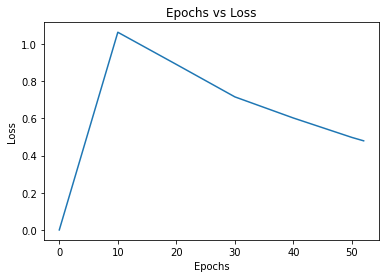

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,loss_rec)
plt.title('Epochs vs Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.locator_params(axis="x", integer=True)
plt.show()

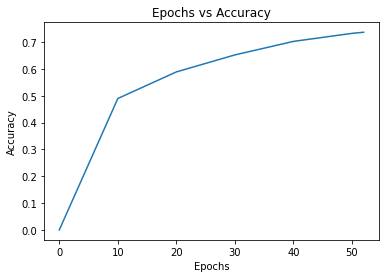

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,acc_rec)
plt.title('Epochs vs Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.locator_params(axis="x", integer=True)
plt.show()

In [ ]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 70.2%, Avg loss: 0.753747 



#LSTM

In [ ]:
class LSTM(nn.Module):
    #this time we'll let our init take arguments for what the 
    #input/output size and various other hyperparameters can be
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(LSTM, self).__init__()


        #number features hidden
        self.input_size = input_size
        self.hidden_size = hidden_size
        #number of hidden layers
        self.layer_size = layer_size
        self.output_size = output_size
        
        #https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        #note - empty h_0 and c_0 arguments will initialize to 0 if not provided
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True)
        
        self.lstm_filter = nn.Linear(input_size, hidden_size)
        self.op = nn.Linear(hidden_size, output_size)

        
    def forward(self,x):
        out, hncn = self.lstm(x)
        out = out.view(len(out),-1)
        out = self.op(out)
        return out

In [ ]:
#Code snippet attribution:
#https://pytorch.org/tutorials/beginner/basics/intro.html
#was used as part of the research process
#Modifications were made so that data could be processed as longs,
#additional statistics could be reported, 
#and a separate validate process was created. 

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    end = math.floor(size/batch_size)
    #print(size)
    #print(end)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #print(X.size())
        #print(batch)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long()) #loss function requires longs

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current =  batch * len(X)
        #When all batches complete
        if batch % 100 == 0:
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            #return (loss, correct) #"correct" corresponds to accuracy
        if (batch>=end): #on last value of enumerate
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print("epoch over")
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            return (loss, correct) #"correct" corresponds to accuracy

#validation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

#test - only use when training/validation are over
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#We'll use same loss and SGD as last time
input_s = 7 #input features (7 measured values)
hidden_s = 256 # hidden features
layer_s = 2 # #of hidden layers
output_s = 5 #output features - (5 possible actions)

model = LSTM(input_s,hidden_s,layer_s,output_s).to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) 

LSTM(
  (lstm): LSTM(7, 256, num_layers=2, batch_first=True)
  (lstm_filter): Linear(in_features=7, out_features=256, bias=True)
  (op): Linear(in_features=256, out_features=5, bias=True)
)


In [ ]:
#Measure validation, and stop the NN if learning has stopped
#increasing in validation
epochs = 100
bestval = 0
decval = 0

loss_rec = [0]
acc_rec = [0]
epo_rec = [0]
#store loss and accuracy every 10 epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losst, acct = train(train_dataloader, model, loss_fn, optimizer)
    #losst = la_tuple[0]
    #acct = la_tuple[1]
    print("val")
    tempval = validate(val_dataloader, model, loss_fn)
    #if (t+1) % 10 == 0: #change to desired epoch records factor - e.g. t+1 % 10 every 10 epochs
    if 1==1: #test statement
      loss_rec.append(losst)
      acc_rec.append(acct)
      epo_rec.append(t+1)

    if(tempval < bestval):
      decval+=1 
      if(decval==3):
        loss_rec.append(losst)
        acc_rec.append(acct)
        epo_rec.append(t+1)
        print("Validation no longer rising. Done!")
        break
    else:
      bestval=tempval
print("Max number of epochs hit or validation stop reached. Done!")

Epoch 1
-------------------------------
loss: 1.602212  [    0/20380]
Train Error: Accuracy: 19.9%
loss: 1.610298  [ 6400/20380]
Train Error: Accuracy: 19.9%
loss: 1.606982  [12800/20380]
Train Error: Accuracy: 19.9%
loss: 1.607945  [19200/20380]
Train Error: Accuracy: 19.9%
epoch over
loss: 1.606727  [ 8904/20380]
Train Error: Accuracy: 19.9%
val
Val Error: 
 Accuracy: 19.7%, Avg loss: 1.608948 

Epoch 2
-------------------------------
loss: 1.606284  [    0/20380]
Train Error: Accuracy: 19.9%
loss: 1.609784  [ 6400/20380]
Train Error: Accuracy: 19.9%
loss: 1.606624  [12800/20380]
Train Error: Accuracy: 21.5%
loss: 1.607972  [19200/20380]
Train Error: Accuracy: 23.4%
epoch over
loss: 1.608136  [ 8904/20380]
Train Error: Accuracy: 23.9%
val
Val Error: 
 Accuracy: 22.3%, Avg loss: 1.608013 

Epoch 3
-------------------------------
loss: 1.607829  [    0/20380]
Train Error: Accuracy: 23.8%
loss: 1.609398  [ 6400/20380]
Train Error: Accuracy: 22.3%
loss: 1.606129  [12800/20380]
Train Erro

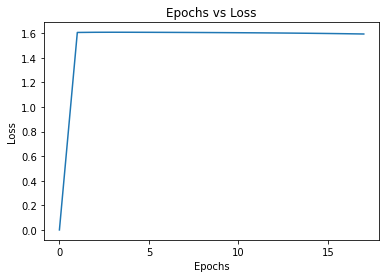

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,loss_rec)
plt.title('Epochs vs Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.locator_params(axis="x", integer=True)
plt.show()

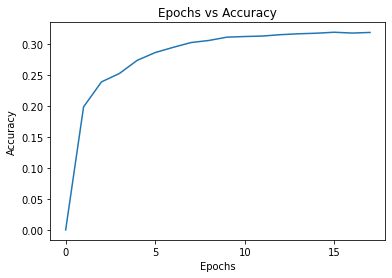

In [ ]:
fig, ax = plt.subplots()
plt.plot(epo_rec,acc_rec)
plt.title('Epochs vs Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.locator_params(axis="x", integer=True)
plt.show()

In [ ]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 32.9%, Avg loss: 1.585926 



#GRU

In [61]:
class GRU(nn.Module):
    #this time we'll let our init take arguments for what the 
    #input/output size and various other hyperparameters can be
    def __init__(self, input_size, hidden_size, layer_size, output_size):
        super(GRU, self).__init__()


        #number features hidden
        self.hidden_size = hidden_size
        #number of hidden layers
        self.layer_size = layer_size
        #https://pytorch.org/docs/stable/generated/torch.nn.GRU.html
        self.gru = nn.GRU(input_size, hidden_size, layer_size, batch_first=True)
        #We need a final output layer 
        self.op = nn.Linear(hidden_size, output_size)

    def forward(self,x):
        #print(x.size())
        # Initialize hidden state with zeros
        #h0 = Variable(torch.zeros(self.layer_size, x.size(0), self.hidden_size))
        h0 = Variable(torch.zeros(self.layer_size, self.hidden_size))
            
        # One time step on RNN
        out, hn = self.gru(x, h0)
        #seq, batch, feature
        out = self.op(out) 
        #out = self.fc(out[:, -1, :]) 
        return out

In [62]:
#Code snippet attribution:
#https://pytorch.org/tutorials/beginner/basics/intro.html
#was used as part of the research process
#Modifications were made so that data could be processed as longs,
#additional statistics could be reported, 
#and a separate validate process was created. 

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    end = math.floor(size/batch_size)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.long()) #loss function requires longs

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current =  batch * len(X)
        #When all batches complete
        if batch % 100 == 0:
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            #return (loss, correct) #"correct" corresponds to accuracy
        if (batch>=end): #on last value of enumerate
            #calculate loss, "correctness" (accuracy)
            #loss, current = loss.item(), batch * len(X)
            loss = loss.item()
            print("epoch over")
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            correct = 0
            with torch.no_grad():
                for X, y in dataloader:
                    X, y = X.to(device), y.to(device)
                    pred = model(X)
                    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            correct /= size
            print(f"Train Error: Accuracy: {(100*correct):>0.1f}%")
            return (loss, correct) #"correct" corresponds to accuracy

#validation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

#test - only use when training/validation are over
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [63]:
#We'll use same loss and SGD as last time
input_s = 7 #input features (7 measured values)
hidden_s = 265 # hidden features
layer_s = 2 # #of hidden layers
output_s = 5 #output features - (5 possible actions)

model = GRU(input_s,hidden_s,layer_s,output_s).to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) 

GRU(
  (gru): GRU(7, 265, num_layers=2, batch_first=True)
  (op): Linear(in_features=265, out_features=5, bias=True)
)


In [64]:
#Measure validation, and stop the NN if learning has stopped
#increasing in validation
epochs = 100
bestval = 0
decval = 0

loss_rec = [0]
acc_rec = [0]
epo_rec = [0]
#store loss and accuracy every 10 epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    losst, acct = train(train_dataloader, model, loss_fn, optimizer)
    tempval = validate(val_dataloader, model, loss_fn)
    #if 1==1: #test statement
    if (t+1) % 10 == 0: #change to desired epoch records factor - e.g. t+1 % 10 every 10 epochs
      loss_rec.append(losst)
      acc_rec.append(acct)
      epo_rec.append(t+1)

    if(tempval < bestval):
      decval+=1 
      if(decval==3):
        loss_rec.append(losst)
        acc_rec.append(acct)
        epo_rec.append(t+1)
        print("Validation no longer rising. Done!")
        break
    else:
      bestval=tempval
print("Max number of epochs hit or validation stop reached. Done!")

Epoch 1
-------------------------------
loss: 1.607778  [    0/20380]
Train Error: Accuracy: 23.7%
loss: 1.605207  [ 6400/20380]
Train Error: Accuracy: 23.8%
loss: 1.605819  [12800/20380]
Train Error: Accuracy: 27.6%
loss: 1.595570  [19200/20380]
Train Error: Accuracy: 31.1%
epoch over
loss: 1.610774  [ 8904/20380]
Train Error: Accuracy: 32.1%
Val Error: 
 Accuracy: 31.3%, Avg loss: 1.598538 

Epoch 2
-------------------------------
loss: 1.602427  [    0/20380]
Train Error: Accuracy: 32.1%
loss: 1.596616  [ 6400/20380]
Train Error: Accuracy: 31.4%
loss: 1.599729  [12800/20380]
Train Error: Accuracy: 32.2%
loss: 1.578959  [19200/20380]
Train Error: Accuracy: 32.8%
epoch over
loss: 1.606571  [ 8904/20380]
Train Error: Accuracy: 32.9%
Val Error: 
 Accuracy: 33.0%, Avg loss: 1.587878 

Epoch 3
-------------------------------
loss: 1.595871  [    0/20380]
Train Error: Accuracy: 32.8%
loss: 1.586779  [ 6400/20380]
Train Error: Accuracy: 32.2%
loss: 1.592271  [12800/20380]
Train Error: Accur

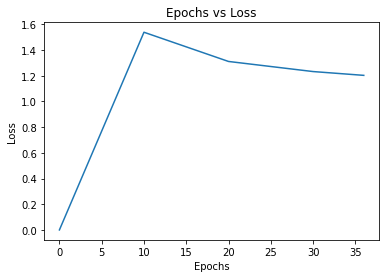

In [66]:
fig, ax = plt.subplots()
plt.plot(epo_rec,loss_rec)
plt.title('Epochs vs Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.locator_params(axis="x", integer=True)
plt.show()

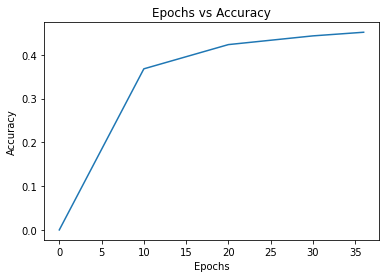

In [67]:
fig, ax = plt.subplots()
plt.plot(epo_rec,acc_rec)
plt.title('Epochs vs Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
plt.locator_params(axis="x", integer=True)
plt.show()

In [68]:
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 45.5%, Avg loss: 1.224221 



#How did this compare to the Feed Forward Network from HW3?


None of the proposed networks were able to perform better than the feed forward network in the same given time span of 100 epochs, with no test accuracy in each individual experiment breaking the 81.7 accuracy benchmark set by HW3. One possible explanation is that the data is simpler and the sequence recordings are not very consistent between actions - a feed forward network looking at the data with less adjustments may need to make less considerations compared to something like an LSTM trying to review the various sequences. It is possible that RNN and similar networks are not a good fit for this problem as a result.

It is also possible that there exist different and/or better hyperparameters that could have been used for each individual model - due to the LSTM issues, I was not able to test them in this experiment. I would likely return to the RNN model and test the hyperparameters again, as it showed the most promising results in terms of accuracy.